In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tqdm
import os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller,acf,pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas import Series

In [5]:
sales=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/sales_train.csv'))
shops=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/shops.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/test.csv'))
item_cat=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/item_categories.csv'))
item=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/items.csv'))

In [14]:
sales['date']=sales.date.apply(lambda x: pd.to_datetime(x))
monthly_sales=sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})

Text(0.5, 1.0, 'Top10 Item Cat by Count')

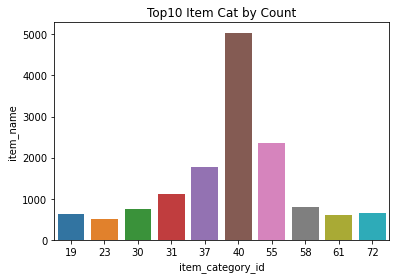

In [26]:
top10_items=item.groupby(['item_category_id']).count().sort_values(by=['item_name'],ascending=False).iloc[:10]
sns.barplot(top10_items.index,top10_items.item_name).set_title('Top10 Item Cat by Count')

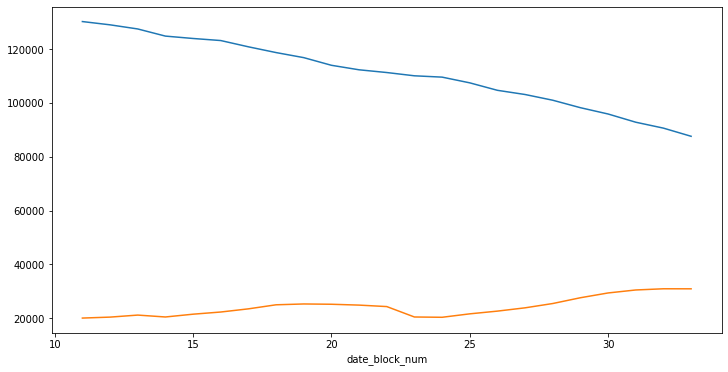

In [60]:
## Mean of accumulated sum to identify trends
ts=sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(12,6))
ts.rolling(window=12,center=False).mean().plot()
ts.rolling(window=12,center=False).std().plot()

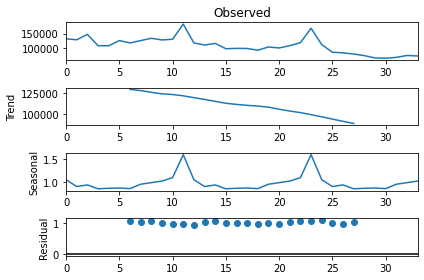

In [87]:
# 'multiplicative model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='multiplicative').plot()
plt.show()

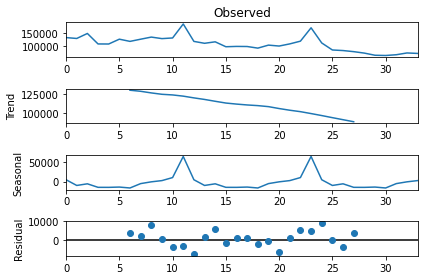

In [90]:
# 'Additive model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='additive').plot()
plt.show()

In [92]:
## Stationarity tests
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dtest=adfuller(ts,autolag='AIC')
    dfoutput=pd.Series(dtest[:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dtest[4].items():
        dfoutput['Critical Value {}'.format(key)]=value
    print(dfoutput)

In [93]:
## P_value >5%
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value 1%              -3.646135
Critical Value 5%              -2.954127
Critical Value 10%             -2.615968
dtype: float64


In [126]:
def difference(df,interval=1):
    diff=[]
    for i in range(interval,len(df)):
        value=df[i]-df[i-interval]
        diff.append(value)
    return pd.Series(diff)
def inverse_diff(last_ob,value):
    return value+last_ob

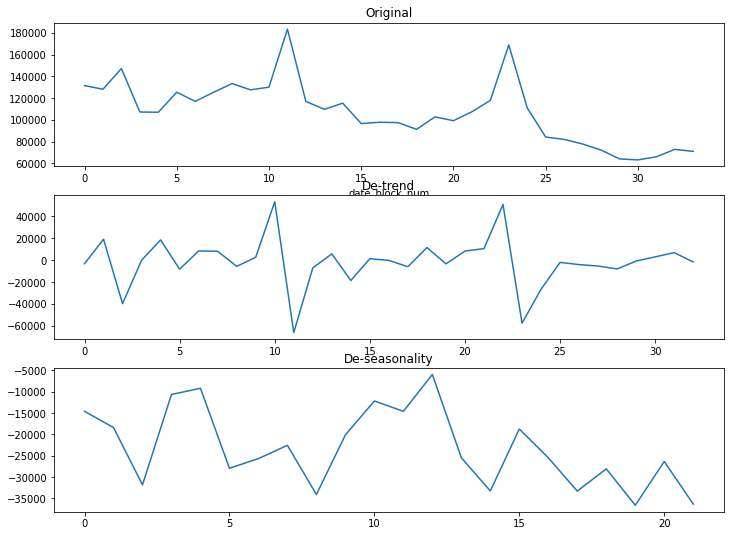

In [147]:
new_ts=difference(ts)
new_12_ts=difference(ts,12)
plt.figure(figsize=(12,9))
plt.subplot(311)
ts.plot(title='Original')
plt.subplot(312)
new_ts.plot(title='De-trend')
plt.subplot(313)
new_12_ts.plot(title='De-seasonality')

In [161]:
test_stationarity(new_12_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value 1%              -3.788386
Critical Value 5%              -3.013098
Critical Value 10%             -2.646397
dtype: float64
